# Reading the dataset
This reads the MNIST hand written digit dataset and creates a subset of the training data with only 10 training examples per class.

In [1]:
import gzip
import cPickle
import numpy as np
import theano
import theano.tensor as T
import random

examples_per_labels = 10


# Load the pickle file for the MNIST dataset.
dataset = 'mnist.pkl.gz'

f = gzip.open(dataset, 'rb')
train_set, dev_set, test_set = cPickle.load(f)
f.close()

#train_set contains 2 entries, first the X values, second the Y values
train_x, train_y = train_set
dev_x, dev_y = dev_set
test_x, test_y = test_set

print 'Train: ', train_x.shape
print 'Dev: ', dev_x.shape
print 'Test: ', test_x.shape

examples = []
examples_labels = []
examples_count = {}

for idx in xrange(train_x.shape[0]):
    label = train_y[idx]
    
    if label not in examples_count:
        examples_count[label] = 0
    
    if examples_count[label] < examples_per_labels:
        arr = train_x[idx]
        examples.append(arr)
        examples_labels.append(label)
        examples_count[label]+=1

train_subset_x = np.asarray(examples)
train_subset_y = np.asarray(examples_labels)

print "Train Subset: ",train_subset_x.shape



Couldn't import dot_parser, loading of dot files will not be possible.
Train:  (50000, 784)
Dev:  (10000, 784)
Test:  (10000, 784)
Train Subset:  (100, 784)


# Baseline
We use a feed forward network to train on the subset and to derive a accurarcy.

In [2]:
from keras.layers import containers
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, AutoEncoder, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

random.seed(1)
np.random.seed(1)

nb_epoch = 50
batch_size = 100
nb_labels = 10

train_subset_y_cat = np_utils.to_categorical(train_subset_y, nb_labels)
dev_y_cat = np_utils.to_categorical(dev_y, nb_labels)
test_y_cat = np_utils.to_categorical(test_y, nb_labels)

model = Sequential()
model.add(Dense(1000, input_dim=train_x.shape[1], activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(nb_labels, activation='softmax'))




model.compile(loss='categorical_crossentropy', optimizer='Adam')
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0)

print('Start training')
model.fit(train_subset_x, train_subset_y_cat, batch_size=batch_size, nb_epoch=nb_epoch,
          show_accuracy=True, verbose=True, validation_data=(dev_x, dev_y_cat), callbacks=[earlyStopping])

score = model.evaluate(test_x, test_y_cat, show_accuracy=True, verbose=False)
print('Test accuracy:', score[1])

Start training
Train on 100 samples, validate on 10000 samples
Epoch 1/50
100/100 [==============================] - 0s - loss: 2.3655 - acc: 0.0800 - val_loss: 2.1055 - val_acc: 0.3374
Epoch 2/50
100/100 [==============================] - 1s - loss: 2.0019 - acc: 0.4000 - val_loss: 1.9175 - val_acc: 0.4715
Epoch 3/50
100/100 [==============================] - 0s - loss: 1.7259 - acc: 0.6000 - val_loss: 1.7535 - val_acc: 0.5706
Epoch 4/50
100/100 [==============================] - 0s - loss: 1.4839 - acc: 0.7300 - val_loss: 1.6082 - val_acc: 0.6290
Epoch 5/50
100/100 [==============================] - 0s - loss: 1.2680 - acc: 0.8200 - val_loss: 1.4812 - val_acc: 0.6623
Epoch 6/50
100/100 [==============================] - 1s - loss: 1.1159 - acc: 0.8500 - val_loss: 1.3721 - val_acc: 0.6785
Epoch 7/50
100/100 [==============================] - 0s - loss: 0.9225 - acc: 0.9000 - val_loss: 1.2825 - val_acc: 0.6884
Epoch 8/50
100/100 [==============================] - 1s - loss: 0.7788 - ac

# Autoencoder - Pretraining
This is the code how the autoencoder should work in principle. However, the pretraining does not workly too good, as is has no real impact when then trained on the labeld data. But it gives some useful representations for the data.

In [4]:
# Train the autoencoder
# Source: https://github.com/fchollet/keras/issues/358
from keras.layers import containers
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, AutoEncoder, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

random.seed(3)
np.random.seed(3)



nb_epoch_pretraining = 10
batch_size_pretraining = 500


# Layer-wise pretraining
encoders = []
decoders = []
nb_hidden_layers = [train_x.shape[1], 500, 2]
X_train_tmp = np.copy(train_x)

dense_layers = []

for i, (n_in, n_out) in enumerate(zip(nb_hidden_layers[:-1], nb_hidden_layers[1:]), start=1):
    print('Training the layer {}: Input {} -> Output {}'.format(i, n_in, n_out))
    # Create AE and training
    ae = Sequential()
    if n_out >= 100:
        encoder = containers.Sequential([Dense(output_dim=n_out, input_dim=n_in, activation='tanh'), Dropout(0.5)])
    else:
        encoder = containers.Sequential([Dense(output_dim=n_out, input_dim=n_in, activation='tanh')])
    decoder = containers.Sequential([Dense(output_dim=n_in, input_dim=n_out, activation='tanh')])
    ae.add(AutoEncoder(encoder=encoder, decoder=decoder, output_reconstruction=False))
    
    sgd = SGD(lr=2, decay=1e-6, momentum=0.0, nesterov=True)
    ae.compile(loss='mse', optimizer='adam')
    ae.fit(X_train_tmp, X_train_tmp, batch_size=batch_size_pretraining, nb_epoch=nb_epoch_pretraining, verbose = True, shuffle=True)
    # Store trainined weight and update training data
    encoders.append(ae.layers[0].encoder)
    decoders.append(ae.layers[0].decoder)
    
    X_train_tmp = ae.predict(X_train_tmp)
    

    


##############
    
    
    
    

#End to End Autoencoder training    
if len(nb_hidden_layers) > 2:
    full_encoder = containers.Sequential()
    for encoder in encoders:
        full_encoder.add(encoder)

    full_decoder = containers.Sequential()
    for decoder in reversed(decoders):
        full_decoder.add(decoder)

    full_ae = Sequential()
    full_ae.add(AutoEncoder(encoder=full_encoder, decoder=full_decoder, output_reconstruction=False))    
    full_ae.compile(loss='mse', optimizer='adam')

    print "Pretraining of full AE"
    full_ae.fit(train_x, train_x, batch_size=batch_size_pretraining, nb_epoch=nb_epoch_pretraining, verbose = True, shuffle=True)



Training the layer 1: Input 784 -> Output 500
Epoch 1/10
50000/50000 [==============================] - 9s - loss: 0.0386     
Epoch 2/10
50000/50000 [==============================] - 8s - loss: 0.0192     
Epoch 3/10
50000/50000 [==============================] - 8s - loss: 0.0163     
Epoch 4/10
50000/50000 [==============================] - 8s - loss: 0.0151     
Epoch 5/10
50000/50000 [==============================] - 8s - loss: 0.0144     
Epoch 6/10
50000/50000 [==============================] - 9s - loss: 0.0139     
Epoch 7/10
50000/50000 [==============================] - 8s - loss: 0.0136     
Epoch 8/10
50000/50000 [==============================] - 8s - loss: 0.0132     
Epoch 9/10
50000/50000 [==============================] - 8s - loss: 0.0129     
Epoch 10/10
50000/50000 [==============================] - 9s - loss: 0.0127     
Training the layer 2: Input 500 -> Output 2
Epoch 1/10
50000/50000 [==============================] - 0s - loss: 0.0248     
Epoch 2/10
50000/5

# Plot Autoencoder
Here we are going to plot the output of the autoencoder (dimension of the last hidden layer should be 2).

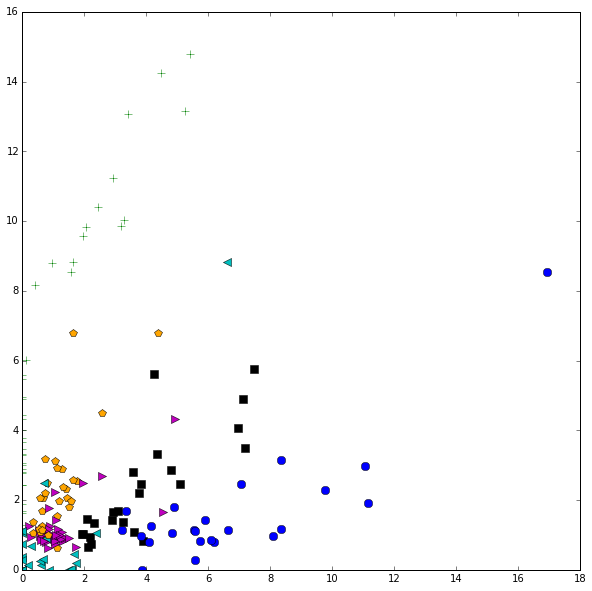

In [6]:
############
# Plot it
############
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

model = Sequential()
for encoder in encoders:
    model.add(encoder)
model.compile(loss='categorical_crossentropy', optimizer='Adam')

ae_test = model.predict(test_x)

colors = {0: 'b', 1: 'g', 2: 'r', 3:'c', 4:'m',
          5:'y', 6:'k', 7:'orange', 8:'darkgreen', 9:'maroon'}

markers = {0: 'o', 1: '+', 2: 'v', 3:'<', 4:'>',
          5:'^', 6:'s', 7:'p', 8:'*', 9:'x'}

plt.figure(figsize=(10, 10)) 
patches = []
for idx in xrange(0,300):    
    point = ae_test[idx]
    label = test_y[idx]
    
    if label in [2,5,8,9]: #We skip these labels to make the plot clearer
        continue
    
    color = colors[label]
    marker = markers[label]
    line = plt.plot(point[0], point[1], color=color, marker=marker, markersize=8)
        
#plt.axis([-1.1, 1.1, -1.1, +1.1])

# PCA
In comparison we are going to plot also an PCA image.

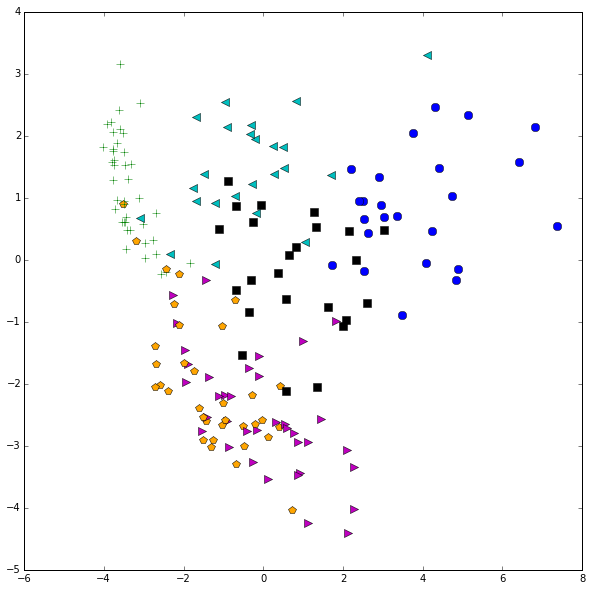

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train_x)

pca_test = pca.transform(test_x)

colors = {0: 'b', 1: 'g', 2: 'r', 3:'c', 4:'m',
          5:'y', 6:'k', 7:'orange', 8:'darkgreen', 9:'maroon'}

markers = {0: 'o', 1: '+', 2: 'v', 3:'<', 4:'>',
          5:'^', 6:'s', 7:'p', 8:'*', 9:'x'}

plt.figure(figsize=(10, 10)) 
patches = []
for idx in xrange(0,300):    
    point = pca_test[idx]
    label = test_y[idx]
    if label in [2,5,8,9]:
        continue
    color = colors[label]
    marker = markers[label]
    line = plt.plot(point[0], point[1], color=color, marker=marker, markersize=8)
        
#plt.axis([-1.1, 1.1, -1.1, +1.1])
plt.show()

# k-Means clustering
We run a k-means clustering on the AutoEncoder representations and the PCA representations and then do a majority voting to get the label per cluster. We then compute the accurarcy of the clustering. This gives us some impression how good the 2-dim representations are. This is not perfect, as AutoEncoder and PCA might create non-linear cluster boundaries.

In [8]:
from sklearn.cluster import KMeans
import operator

def clusterAccurarcy(predictions, n_clusters=10):
    km = KMeans(n_clusters=n_clusters)

    clusters = km.fit_predict(predictions)

    #Count labels per cluster
    labelCount = {}

    for idx in xrange(len(test_y)):
        cluster = clusters[idx]
        label = test_y[idx]

        if cluster not in labelCount:
            labelCount[cluster] = {}

        if label not in labelCount[cluster]:
            labelCount[cluster][label] = 0

        labelCount[cluster][label] += 1

    #Majority Voting
    clusterLabels = {}
    for num in xrange(n_clusters):    
        maxLabel = max(labelCount[num].iteritems(), key=operator.itemgetter(1))[0]
        clusterLabels[num] = maxLabel
    #print clusterLabels
    #Number of errors
    errCount = 0
    for idx in xrange(len(test_y)):
        cluster = clusters[idx] 
        clusterLabel = clusterLabels[cluster]
        label = test_y[idx]

        if label != clusterLabel:
            errCount += 1
    
    return errCount/float(len(test_y))
        
print "PCA Accurarcy: %f%%" % (clusterAccurarcy(pca_test)*100)
print "AE Accurarcy: %f%%" % (clusterAccurarcy(ae_test)*100)
    

PCA Accurarcy: 57.900000%
AE Accurarcy: 61.130000%


# Using pretrained AutoEncoder for Classification
In principle the pretrained AutoEncoder could be used for classification as in the following code. But it does not yet result to better results than the Neural Network without pretraining.

In [9]:
nb_epoch = 50
batch_size = 100

model = Sequential()
for encoder in encoders:
    model.add(encoder)
    

model.add(Dense(output_dim=nb_labels, activation='softmax'))

train_subset_y_cat = np_utils.to_categorical(train_subset_y, nb_labels)
test_y_cat = np_utils.to_categorical(test_y, nb_labels)




model.compile(loss='categorical_crossentropy', optimizer='Adam')
score = model.evaluate(test_x, test_y_cat, show_accuracy=True, verbose=0)
print('Test score before fine turning:', score[0])
print('Test accuracy before fine turning:', score[1])
model.fit(train_subset_x, train_subset_y_cat, batch_size=batch_size, nb_epoch=nb_epoch,
          show_accuracy=True, validation_data=(dev_x, dev_y_cat), shuffle=True)
score = model.evaluate(test_x, test_y_cat, show_accuracy=True, verbose=0)
print('Test score after fine turning:', score[0])
print('Test accuracy after fine turning:', score[1])
 

('Test score before fine turning:', 4.8862177627563472)
('Test accuracy before fine turning:', 0.067799999999999999)
Train on 100 samples, validate on 10000 samples
Epoch 1/50
100/100 [==============================] - 0s - loss: 5.1481 - acc: 0.0500 - val_loss: 4.7258 - val_acc: 0.0712
Epoch 2/50
100/100 [==============================] - 0s - loss: 4.6525 - acc: 0.0500 - val_loss: 4.4477 - val_acc: 0.0731
Epoch 3/50
100/100 [==============================] - 0s - loss: 4.3487 - acc: 0.0500 - val_loss: 4.1904 - val_acc: 0.0743
Epoch 4/50
100/100 [==============================] - 0s - loss: 4.0998 - acc: 0.0500 - val_loss: 3.9535 - val_acc: 0.0767
Epoch 5/50
100/100 [==============================] - 0s - loss: 3.7961 - acc: 0.0600 - val_loss: 3.7355 - val_acc: 0.0786
Epoch 6/50
100/100 [==============================] - 0s - loss: 3.4519 - acc: 0.0500 - val_loss: 3.5363 - val_acc: 0.0812
Epoch 7/50
100/100 [==============================] - 0s - loss: 3.1851 - acc: 0.0500 - val_loss: